# Import Libraries

In [31]:
# Import necessary libraries and functions
import pandas as pd
import numpy as np
from pathlib import Path

# Modeling + evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)
import matplotlib.pyplot as plt

# Set up helper functions and constants
* Defines constants and small helper functions that will be reused later when cleaning and transforming raw tables

In [32]:
# Sets reference date for calculating things like account age
DATA_CUTOFF = pd.to_datetime("2025-07-01")  # end of data window (per brief)

# Set random seed for reproducibility.
RANDOM_STATE = 42

# Safe wrapper around pd.read_csv
def safe_read(name):
    p = Path(name)
    if not p.exists():
        raise FileNotFoundError(f"Missing file: {name} (expected in {Path.cwd()})")
    return pd.read_csv(p)

# Helper for session aggregation
# Takes user’s first session and last session, and computes how many weeks they’ve been active
def weeks_between(min_ts, max_ts):
    if pd.isna(min_ts) or pd.isna(max_ts) or max_ts < min_ts:
        return np.nan
    return max(1.0, (max_ts - min_ts).days / 7.0)

# Read the raw CSVs and standardize data types
* Loads the raw data (users, sessions, events, billing)
* Standardizes date/time columns into a consistent datetime format
* Prepares the data for feature engineering

In [33]:
# Loads each dataset into a pandas DataFrame
users   = safe_read("users.csv") # safe_read() gives error message if file is missing
sessions= safe_read("sessions.csv")
events  = safe_read("events.csv")
billing = safe_read("billing.csv")

# Converts the signup_date column into a datetime object.
for col in ["signup_date"]:
    if col in users.columns:
        users[col] = pd.to_datetime(users[col], errors="coerce") # errors="coerce" means if a row has something invalid, doesn't crash

# Ensure session_start and session_end are proper datetimes
# Allows us to compute session length, first session date, and last session date per user
for col in ["session_start", "session_end"]:
    if col in sessions.columns:
        sessions[col] = pd.to_datetime(sessions[col], errors="coerce")

# Converts the event timestamp (ts) into datetime
if "ts" in events.columns:
    events["ts"] = pd.to_datetime(events["ts"], errors="coerce")

# Feature Engineering
* Turns raw logs → engineered features (numeric + categorical inputs).
* Organizes them into per-user rows (so every user has one feature vector)
* Creates the foundation for the churn prediction dataset

### Users
* Anchor table — one row per user
* Contains demographics (plan_tier, company_size, region), acquisition channel and churn label (churned_30d, churned_90d)
* Gives who the user is and provides the target variable (Y)

In [34]:
# Choose 90-day churn horizon
label_col = "churned_90d" if "churned_90d" in users.columns else "churned_30d" # If 90 days not in users, choose 30 days
if label_col not in users.columns:
    raise ValueError("Neither churned_90d nor churned_30d exists in users.csv") # Error message

user_feats = users.copy()

# Calculate account age (days since signup to data cutoff)
if "signup_date" in user_feats.columns:
    user_feats["account_age_days"] = (DATA_CUTOFF - user_feats["signup_date"]).dt.days
    user_feats.drop(columns=["signup_date"], inplace=True, errors="ignore")

## Sessions
* Raw sessions logs → aggregated into behavioral metrics like sessions_per_week, avg_session_length, device_variety
* Captures how much the user engages with Atlassian products.

In [35]:
if len(sessions) > 0:
    ses = sessions.copy()
    # Safety: if session_length_sec missing, compute from start/end
    if "session_length_sec" not in ses.columns and {"session_start", "session_end"} <= set(ses.columns):
        ses["session_length_sec"] = (ses["session_end"] - ses["session_start"]).dt.total_seconds()

    # per-user aggregates
    ses_agg = ses.groupby("user_id").agg(
        sessions_count=("session_id", "nunique"),
        avg_session_length=("session_length_sec", "mean"),
        p75_session_length=("session_length_sec", lambda x: np.nanpercentile(x, 75)),
        first_session=("session_start", "min"),
        last_session=("session_end", "max"),
        device_variety=("device", pd.Series.nunique) if "device" in ses.columns else ("session_id", "count"),
        os_variety=("os", pd.Series.nunique) if "os" in ses.columns else ("session_id", "count"),
        app_version_variety=("app_version", pd.Series.nunique) if "app_version" in ses.columns else ("session_id", "count"),
        country_variety=("country", pd.Series.nunique) if "country" in ses.columns else ("session_id", "count")
    )

    # weeks active + sessions per week
    ses_agg["weeks_active"] = (ses_agg.apply(lambda r: weeks_between(r["first_session"], r["last_session"]), axis=1))
    ses_agg["sessions_per_week"] = ses_agg["sessions_count"] / ses_agg["weeks_active"]

    # Clean up infinities
    ses_agg.replace([np.inf, -np.inf], np.nan, inplace=True)
else:
    ses_agg = pd.DataFrame(columns=["user_id"])  # empty (edge case)


## Events (feature adoption features)
* Product usage logs → aggregated into unique_features_used, success_rate, days_to_first_event.
* Captures what the user is doing inside the product and how effectively.

In [36]:
if len(events) > 0:
    ev = events.copy()
    ev_agg = ev.groupby("user_id").agg(
        total_events=("event_id", "nunique"),
        unique_features_used=("feature_name", pd.Series.nunique),
        success_rate=("success", "mean") if "success" in ev.columns else ("event_id", "count"),
        avg_latency_ms=("latency_ms", "mean") if "latency_ms" in ev.columns else ("event_id", "count"),
        first_event=("ts", "min"),
        last_event=("ts", "max")
    )

    # time to first feature use since signup (days)
    if "first_event" in ev_agg.columns and "signup_date" in users.columns:
        ev_agg = ev_agg.merge(users[["user_id", "signup_date"]], on="user_id", how="left")
        ev_agg["days_to_first_event"] = (ev_agg["first_event"] - ev_agg["signup_date"]).dt.days
        ev_agg.drop(columns=["signup_date"], inplace=True, errors="ignore")
else:
    ev_agg = pd.DataFrame(columns=["user_id"])

## Billing (financial health features)
* Invoices and payments → aggregated into avg_mrr, ever_overdue, total_tickets
* Captures the business relationship health (financial reliability, support burden)

In [37]:
# 2.4 Billing-level features (financial health)
if len(billing) > 0:
    bill = billing.copy()
    if "month" in bill.columns:
        # parse month if provided as string
        bill["month"] = pd.to_datetime(bill["month"], errors="coerce")

    bill_agg = bill.groupby("user_id").agg(
        avg_mrr=("mrr", "mean") if "mrr" in bill.columns else ("user_id", "size"),
        max_mrr=("mrr", "max") if "mrr" in bill.columns else ("user_id", "size"),
        min_mrr=("mrr", "min") if "mrr" in bill.columns else ("user_id", "size"),
        months_billed=("month", "nunique") if "month" in bill.columns else ("user_id", "size"),
        ever_overdue=("invoices_overdue", "max") if "invoices_overdue" in bill.columns else ("user_id", "size"),
        total_tickets=("support_ticket_count", "sum") if "support_ticket_count" in bill.columns else ("user_id", "size"),
        discount_ever=("discount_applied", "max") if "discount_applied" in bill.columns else ("user_id", "size"),
        active_seats_max=("active_seats", "max") if "active_seats" in bill.columns else ("user_id", "size"),
    )
else:
    bill_agg = pd.DataFrame(columns=["user_id"])

# Merging
* Feature engineering gets combined into a single dataset to feed into a machine learning model

In [38]:
df = user_feats.merge(ses_agg.reset_index(), on="user_id", how="left")
df = df.merge(ev_agg.reset_index(), on="user_id", how="left")
df = df.merge(bill_agg.reset_index(), on="user_id", how="left")

# Target
y = df[label_col].astype(int)

# Drop identifiers / leakage columns
drop_cols = ["user_id", label_col, "first_session", "last_session", "first_event", "last_event"]
X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

# Train / Test split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE
)

# Preprocess
* Prepare features (X) so they’re in a form that machine learning models can use

In [40]:
# Splits features into categorical (e.g., plan_tier, region) and numeric (e.g., avg_session_length, account_age_days)
# Models like logistic regression can’t handle raw strings → we need to encode them
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X_train.select_dtypes(include=["number", "bool"]).columns.tolist()

# Imputer: fills in missing values with the median (robust against outliers)
# Scaler: normalizes numeric features (so values like 1000 MRR and 0.3 success rate are on comparable scales)
numeric_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))  # with_mean False to be safe with sparse concat
])

# Imputer: fills missing categories with the most common one.
# OneHotEncoder: turns categories into binary columns.
# Example: plan_tier = Premium → [Free=0, Standard=0, Premium=1, Enterprise=0].
# handle_unknown="ignore": prevents errors if a new category shows up at test time.
categorical_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

# Combines the numeric and categorical pipelines.
# Applies each transformation to the right columns.
# Now, every row becomes a fully numeric feature vector ready for modeling.
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, num_cols),
        ("cat", categorical_tf, cat_cols),
    ],
    remainder="drop"
)

# Models (Attempt 1)
* Logistic (interpretable)
* RandomForest (nonlinear)

In [41]:
logit = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=None))  # n_jobs added in 1.6+
])

rf = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=400, max_depth=None, random_state=RANDOM_STATE,
        class_weight="balanced_subsample", n_jobs=-1
    ))
])

In [42]:
# Fit
logit.fit(X_train, y_train)
rf.fit(X_train, y_train)

,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Evaluation


Logistic Regression
-------------------
ROC AUC:         0.679
PR AUC (AP):     0.335
Confusion matrix:
 [[12211 10891]
 [ 1671  5227]]

Classification report:
               precision    recall  f1-score   support

           0      0.880     0.529     0.660     23102
           1      0.324     0.758     0.454      6898

    accuracy                          0.581     30000
   macro avg      0.602     0.643     0.557     30000
weighted avg      0.752     0.581     0.613     30000



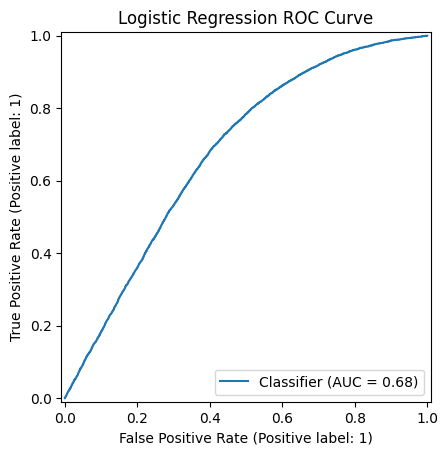

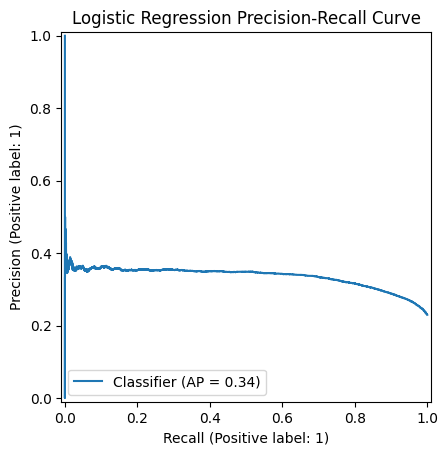


Random Forest
-------------
ROC AUC:         0.67
PR AUC (AP):     0.334
Confusion matrix:
 [[22153   949]
 [ 6327   571]]

Classification report:
               precision    recall  f1-score   support

           0      0.778     0.959     0.859     23102
           1      0.376     0.083     0.136      6898

    accuracy                          0.757     30000
   macro avg      0.577     0.521     0.497     30000
weighted avg      0.685     0.757     0.693     30000



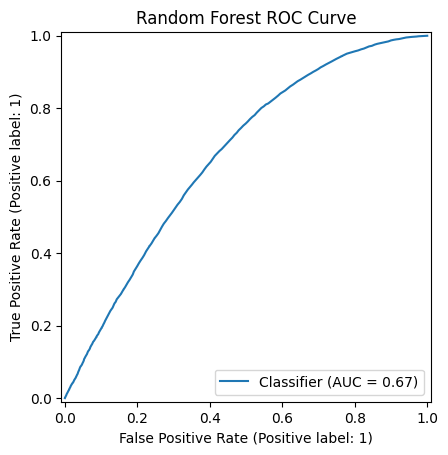

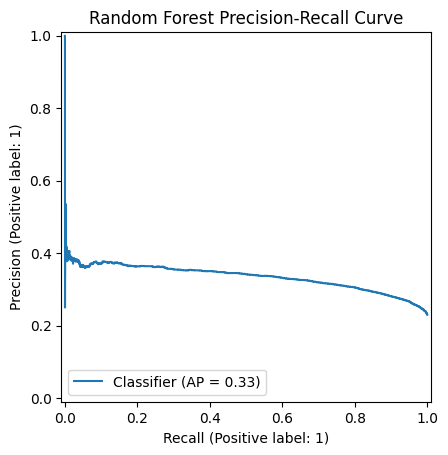

In [43]:
def eval_model(name, pipe):
    y_prob = pipe.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    roc = roc_auc_score(y_test, y_prob)
    ap  = average_precision_score(y_test, y_prob)  # PR AUC
    cm  = confusion_matrix(y_test, y_pred)
    print(f"\n{name}")
    print("-" * len(name))
    print("ROC AUC:        ", round(roc, 3))
    print("PR AUC (AP):    ", round(ap, 3))
    print("Confusion matrix:\n", cm)
    print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3))

    # Curves
    RocCurveDisplay.from_predictions(y_test, y_prob)
    plt.title(f"{name} ROC Curve")
    plt.show()

    PrecisionRecallDisplay.from_predictions(y_test, y_prob)
    plt.title(f"{name} Precision-Recall Curve")
    plt.show()

eval_model("Logistic Regression", logit)
eval_model("Random Forest", rf)

## Notes on Logisitic Regression
ROC AUC = 0.679
* Scale: 0.5 = random guessing, 1.0 = perfect
* 0.679 = the model is better than random, but not amazing
* In churn prediction, AUC ~0.65–0.75 is common for a first pass (users are noisy, churn is multi-factorial)

PR AUC (AP) = 0.335
* Precision–Recall curve is important when classes are imbalanced (churners < non-churners)
* A baseline would be the churn rate (≈ 0.23 = 6898 / 30000)
* 0.335 > 0.23 → your model is catching churners better than random, though still with room to improve

Confusion Matrix
* The model recalls a lot of churners (5,227/6,898 ≈ 76%)
* But it also flags many false churns (10,891 false positives)

**Classification Report**

Class 0 (retained):
* Precision = 0.880 → when the model says “not churn,” it’s right most of the time.
* Recall = 0.529 → but it misses many of them.

Class 1 (churn):
* Precision = 0.324 → only 32% of predicted churners actually churn.
* Recall = 0.758 → catches most churners (good for early intervention).

Overall accuracy = 58%
* Looks low, but accuracy is misleading here because churn is imbalanced.
* Recall and precision for churners matter more than raw accuracy.

**Interpretation for Atlassian Storytelling**
* Strength: The model is good at catching churners early (76% recall)
* Weakness: It over-predicts churn (many false alarms)
* Business implication:
* If Atlassian wants to proactively support at-risk users, this is okay (better safe than sorry)
* But if outreach is costly, you’ll need to improve precision (fewer false alarms)

## Notes on Logisitic Regression
**ROC AUC = 0.67**
* Similar to Logistic Regression (0.679)
* Slightly worse than logistic, but still above random (0.5)
* Tells us the RF isn’t capturing much extra non-linear signal here

**PR AUC (AP) = 0.334**
* Almost the same as Logistic Regression (0.335)
* Model is only a bit better than the baseline churn rate (~23%)
* Means the challenge isn’t model choice alone — it’s also about richer features

**Confusion Matrix**
* RF is very conservative — it almost never predicts churn
* It’s extremely good at recognizing non-churners (very high true negatives)
* But it misses most churners (recall for churn = only 8.3%)

**Classification Report**
Class 0 (retained):
* Precision = 0.778 → when it says “retained,” it’s usually right
* Recall = 0.959 → almost all non-churners are caught correctly

Class 1 (churn):
* Precision = 0.376 → when it says “churn,” ~38% are actual churners
* Recall = 0.083 → it only catches 8% of churners

Accuracy = 0.757
* Looks higher than Logistic Regression (0.581), but this is misleading:
* It comes from predicting “not churn” most of the time, which is easy since churners are a minority


## Comparing
Logistic Regression:
* Recall (churn) = 0.758 → good at finding churners, but many false alarms.
* Precision (churn) = 0.324 → lots of false positives.

Random Forest:
* Recall (churn) = 0.083 → terrible at finding churners (almost blind).
* Precision (churn) = 0.376 → when it does guess churn, it’s a bit better than logistic.

# Explainability

In [44]:
# Helper: recover feature names after ColumnTransformer
def get_feature_names(prep: ColumnTransformer):
    num_features = num_cols
    # categorical names via OHE
    ohe = prep.named_transformers_["cat"].named_steps["ohe"]
    cat_features = ohe.get_feature_names_out(cat_cols).tolist()
    return num_features + cat_features

In [45]:
# 8a) Logistic regression coefficients (odds ratios)
try:
    log_coefs = logit.named_steps["clf"].coef_[0]
    feat_names = get_feature_names(logit.named_steps["prep"])
    coef_df = pd.DataFrame({
        "feature": feat_names,
        "coef": log_coefs,
        "odds_ratio": np.exp(log_coefs)
    }).sort_values("odds_ratio", ascending=False)

    print("\nTop positive churn drivers (Logistic, odds ratio):")
    print(coef_df.head(15).to_string(index=False))

    print("\nTop retention drivers (reduce churn, odds ratio < 1):")
    print(coef_df.tail(15).sort_values("odds_ratio").to_string(index=False))
except Exception as e:
    print("Could not compute logistic coefficients:", e)


Top positive churn drivers (Logistic, odds ratio):
             feature     coef  odds_ratio
      plan_tier_free 0.687693    1.989121
    account_age_days 0.628027    1.873909
 app_version_variety 0.322811    1.381004
 days_to_first_event 0.193231    1.213163
             avg_mrr 0.178676    1.195633
   company_size_1-10 0.113863    1.120599
  avg_session_length 0.092070    1.096441
unique_features_used 0.086318    1.090153
      avg_latency_ms 0.066755    1.069034
       total_tickets 0.045757    1.046820
        success_rate 0.040842    1.041687
      industry_media 0.038549    1.039301
      device_variety 0.034542    1.035145
        ever_overdue 0.033975    1.034559
             min_mrr 0.022006    1.022250

Top retention drivers (reduce churn, odds ratio < 1):
                    feature      coef  odds_ratio
          plan_tier_premium -0.793551    0.452236
              months_billed -0.661317    0.516171
             sessions_count -0.373780    0.688128
                    m


Top features (Random Forest importance):
                feature  importance
       account_age_days    0.128560
       active_seats_max    0.081021
    days_to_first_event    0.062273
          months_billed    0.061897
     p75_session_length    0.045179
     avg_session_length    0.044981
          total_tickets    0.038856
         avg_latency_ms    0.034253
                  index    0.032831
                avg_mrr    0.031438
                min_mrr    0.027796
      sessions_per_week    0.026958
           weeks_active    0.026878
                max_mrr    0.024124
         sessions_count    0.017879
           total_events    0.014764
    app_version_variety    0.014220
         plan_tier_free    0.013743
            churned_30d    0.013528
acquisition_channel_seo    0.012364


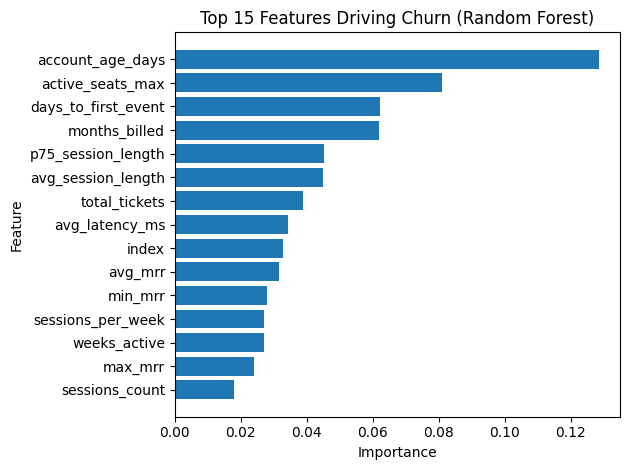

In [46]:
# 8b) Random Forest feature importance
try:
    rf_importances = rf.named_steps["clf"].feature_importances_
    feat_names = get_feature_names(rf.named_steps["prep"])
    imp_df = pd.DataFrame({"feature": feat_names, "importance": rf_importances}) \
             .sort_values("importance", ascending=False)
    print("\nTop features (Random Forest importance):")
    print(imp_df.head(20).to_string(index=False))

    # Bar plot
    top = imp_df.head(15)
    plt.figure()
    plt.barh(top["feature"][::-1], top["importance"][::-1])
    plt.title("Top 15 Features Driving Churn (Random Forest)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Could not compute RF importances:", e)


# Models (Attempt 2: Fine Tuning)